# **Evaluating a RAG Application using Qdrant and RAGAS**

**Introduction**

Creating a foundation for a Retrieval-Augmented Generation (RAG) pipeline is often straightforward. However, optimizing and tweaking it for production and ensuring top-notch response quality presents formidable hurdles. Given the multitude of tools and parameters available, identifying the ideal configuration can feel overwhelming.

In this notebook, we delve into the evaluation, visualization, and analysis of RAG systems using a blend of open-source libraries. Our toolkit includes [Haystack]() [RAGAS](https://docs.ragas.io/) for evaluation and Qdrant for context augmentation, serving as a vector database to construct the RAG pipeline.

Throughout this article, we'll leverage data sourced from [Qdrant](https://qdrant.tech/)'s documentation and articles to create an assistant capable of answering queries about Qdrant. Additionally, we'll explore methods for generating synthetic test data, including those provided by RAGAS.

❗This notebook requires **OpenAI Key**

In [1]:
#pip install qdrant_client datasets langchain pandas fastembed==0.2.6 qdrant-client[fastembed] ragas-haystack matplotlib openai

### **1. Import relevant packages**

In [2]:
import os
import json
import openai
import pandas as pd
import qdrant_client
from getpass import getpass
from tqdm.notebook import tqdm
from datasets import load_dataset
from typing import Optional, List, Tuple
from qdrant_client import QdrantClient, models
from qdrant_client.http.models import PointStruct
from langchain_core.language_models import BaseChatModel

In [3]:
from dotenv import load_dotenv
from haystack import Pipeline
from haystack_integrations.components.evaluators.ragas import RagasEvaluator, RagasMetric

In [6]:
## Load environment variables
load_dotenv()

True

### **2. Setup your openai key**

In [24]:
if not (openai_api_key := os.environ.get("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
openai.api_key = openai_api_key
os.environ["OPENAI_API_KEY"] = openai_api_key

### **3.  Retrieve the documents / dataset to be used**

In [25]:

dataset = load_dataset("atitaarora/qdrant_doc", split="train")


### **4. Process dataset as langchain document for further processing**

In [9]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document as LangchainDocument

## Dataset to langchain document
langchain_docs = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]})
    for doc in tqdm(dataset)
]

len(langchain_docs)

  0%|          | 0/240 [00:00<?, ?it/s]

240

### **5. (Optional) Baseline Test Evaluation Dataset Generation using Ragas**

We can use the testdataset generator from RAGAS or use synthetic evaluation dataset generation through T5 or OpenAI as part of other notebooks.

In [ ]:
from langchain.document_loaders import DirectoryLoader
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context

generator = TestsetGenerator.with_openai()
testset = generator.generate_with_langchain_docs(langchain_docs[:10], test_size=10,
                                                 raise_exceptions=False, with_debugging_logs=False,
                                                 distributions={simple: 0.5, reasoning: 0.25, multi_context: 0.25})

### **5a. Evaluation dataset to Pandas for better visualization**

In [ ]:
df = testset.to_pandas()
df.head(10)

,question,contexts,ground_truth,evolution_type,metadata,episode_done
0,What is the process of downloading and running...,[---\n\ntitle: Quickstart\n\nweight: 11\n\nali...,"First, download the latest Qdrant image from D...",simple,[{'source': 'documentation/quick-start.md'}],True
1,What is the purpose of the Qdrant vector searc...,[---\n\ndraft: false\n\ntitle: Startup Search\...,This demo uses short descriptions of startups ...,simple,[{'source': 'demo/demo-1.md'}],True
2,How do you load data into a Qdrant collection?,[---\n\ntitle: Quickstart\n\nweight: 11\n\nali...,nan,simple,[{'source': 'documentation/quick-start.md'}],True
3,What is the purpose of the Startup Search demo?,[---\n\ndraft: false\n\ntitle: Startup Search\...,This demo uses short descriptions of startups ...,simple,[{'source': 'demo/demo-1.md'}],True
4,What are the next steps after conducting a vec...,"[ string_value: ""London""\n\n }\n\n}\n\nscore:...","Now that you know how Qdrant works, the next s...",simple,[{'source': 'documentation/quick-start.md'}],True
5,What model is used in the startup search demo ...,[---\n\ndraft: false\n\ntitle: Startup Search\...,A pre-trained SentenceTransformer model is use...,reasoning,[{'source': 'demo/demo-1.md'}],True
6,What's the name of the collection created with...,[---\n\ntitle: Quickstart\n\nweight: 11\n\nali...,test_collection,reasoning,[{'source': 'documentation/quick-start.md'}],True
7,What does the SentenceTransformer model do in ...,[---\n\ndraft: false\n\ntitle: Startup Search\...,The SentenceTransformer model in the startup s...,multi_context,"[{'source': 'demo/demo-1.md'}, {'source': 'dem...",True
8,What is the purpose of using short description...,[---\n\ndraft: false\n\ntitle: Startup Search\...,The purpose of using short descriptions of sta...,multi_context,[{'source': 'demo/demo-1.md'}],True
9,What is the purpose of the Qdrant vector searc...,[---\n\ndraft: false\n\ntitle: Startup Search\...,This demo uses short descriptions of startups ...,simple,[{'source': 'demo/demo-1.md'}],True


### **5b. Export the evaluation dataset to csv (if needed)**

In [ ]:
from pathlib import Path
filepath = Path('sample_question_ragas_101.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(filepath)

### **6. Document chunk processing**

Processing each document with desired **TEXT_SPLITTER_ALGO , CHUNK_SIZE , CHUNK_OVERLAP** etc

In [32]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=512,
    chunk_overlap=50,
    add_start_index=True,
    separators=["\n\n", "\n", ".", " ", ""],
)

docs_processed = []
for doc in langchain_docs:
    docs_processed += text_splitter.split_documents([doc])

In [33]:
len(docs_processed)

4431

### **7. Setting up Qdrant**

Set up the qdrant client and then create a collection so that our documents can be stored.

In [13]:

##Uncomment to initialise qdrant client in memory
#client = qdrant_client.QdrantClient(
#    location=":memory:",
#)

##Uncomment below to connect to Qdrant Cloud
client = qdrant_client.QdrantClient(
    os.environ.get("QDRANT_URL"),
    api_key=os.environ.get("QDRANT_API_KEY"),
)

## Uncomment below to connect to local Qdrant
#client = qdrant_client.QdrantClient("http://localhost:6333")

In [30]:
## Collection name that will be used throughtout in the notebook
COLLECTION_NAME = "qdrant-docs-ragas-haystack-mxbai"

In [31]:
## General Collection level operations

## Get information about existing collections
client.get_collections()

## Get information about specific collection
#collection_info = client.get_collection(COLLECTION_NAME)
#print(collection_info)

## Deleting collection , if need be
#client.delete_collection(COLLECTION_NAME)

CollectionsResponse(collections=[CollectionDescription(name='qdrant-docs-ragas-haystack'), CollectionDescription(name='qdrant_docs_arize_dense'), CollectionDescription(name='qdrant_docs_arize_hybrid')])

In [18]:
## Declaring the intended Embedding Model with Fastembed
from fastembed import TextEmbedding

pd.DataFrame(TextEmbedding.list_supported_models())

,model,dim,description,size_in_GB,sources
0,BAAI/bge-base-en,768,Base English model,0.420,{'url': 'https://storage.googleapis.com/qdrant...
1,BAAI/bge-base-en-v1.5,768,"Base English model, v1.5",0.210,{'url': 'https://storage.googleapis.com/qdrant...
2,BAAI/bge-large-en-v1.5,1024,"Large English model, v1.5",1.200,{'hf': 'qdrant/bge-large-en-v1.5-onnx'}
3,BAAI/bge-small-en,384,Fast English model,0.130,{'url': 'https://storage.googleapis.com/qdrant...
4,BAAI/bge-small-en-v1.5,384,Fast and Default English model,0.067,{'hf': 'qdrant/bge-small-en-v1.5-onnx-q'}
5,BAAI/bge-small-zh-v1.5,512,Fast and recommended Chinese model,0.090,{'url': 'https://storage.googleapis.com/qdrant...
6,sentence-transformers/all-MiniLM-L6-v2,384,"Sentence Transformer model, MiniLM-L6-v2",0.090,{'url': 'https://storage.googleapis.com/qdrant...
7,sentence-transformers/paraphrase-multilingual-...,384,"Sentence Transformer model, paraphrase-multili...",0.220,{'hf': 'qdrant/paraphrase-multilingual-MiniLM-...
8,nomic-ai/nomic-embed-text-v1,768,8192 context length english model,0.520,{'hf': 'nomic-ai/nomic-embed-text-v1'}
9,nomic-ai/nomic-embed-text-v1.5,768,8192 context length english model,0.520,{'hf': 'nomic-ai/nomic-embed-text-v1.5'}


In [34]:
##Initilising embedding model
#embedding_model = TextEmbedding()

## For custom model supported by Fastembed
embedding_model = TextEmbedding(model_name="mixedbread-ai/mxbai-embed-large-v1", max_length=1024)


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

config_sentence_transformers.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/113k [00:00<?, ?B/s]

mxbai-embed-large-v1-f16.gguf:   0%|          | 0.00/670M [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

model_quantized.onnx:   0%|          | 0.00/337M [00:00<?, ?B/s]

model_fp16.onnx:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

In [35]:
## Print and validate the embedding model used
## Using Default Model - BAAI/bge-small-en-v1.5
embedding_model.model_name

'mixedbread-ai/mxbai-embed-large-v1'

### **8. Processing chunks into text to be processed by [FASTEMBED](https://qdrant.github.io/fastembed/)**

In [36]:
docs_contents = []
docs_metadatas = []

for doc in docs_processed:
    if hasattr(doc, 'page_content') and hasattr(doc, 'metadata'):
        docs_contents.append(doc.page_content)
        docs_metadatas.append(doc.metadata)
    else:
        # Handle the case where attributes are missing
        print("Warning: Some documents do not have 'page_content' or 'metadata' attributes.")

print("content : ",len(docs_contents))
print("metadata : ",len(docs_metadatas))

content :  4431
metadata :  4431


### **9. Adding document chunks into Qdrant Collection**

In [37]:
client.add(collection_name=COLLECTION_NAME, metadata=docs_metadatas, documents=docs_contents)

['d8805c85ee394e4d975b632f9fb2fbfd',
 'eb0192ea234b46a79966d60c215ee161',
 'bc6b0bb1288f4e0e95afe4f62983af69',
 '8c9bfaeb873c4064801da11f3236c0d3',
 'df204b72e98847048f44fd348bfc9bf6',
 'a5c7e406e6794e1789a4105549292122',
 '370b6afda9824cb893a9cff00c136296',
 '1b77352fb80d431ab2cef41b29807260',
 'f930c11da15340e5a9ceda61d64eb385',
 '32968fd9b9234310a6ec52a670edb008',
 '93d4c547b1d549c6a1f0cfdbe1535524',
 '12f14db6c11840a9a8d36921be2e3f3f',
 'f293e0e0cc814acb8cd6898978d95d21',
 'd2b3d49677c448609b2d91537713860f',
 '5b443bcae8b945efaa6cdd99e4f37928',
 '50bc253360294196ac5ad0602882cb77',
 '9b23efa0238e4825bc3267fcb702586f',
 'd7a88fd29169444daa6d9d32eba34497',
 'a220e75d68164d8ba9202f429629d9b6',
 'ab5384f386b34d6db7a9bb9c9f241c02',
 '32a9ece4049e451fbfeeb33e03f058f4',
 'c24feba724854deb844adc378b993582',
 'c2ba2a228c7e4b258ca676f42cd916fa',
 '8dfa69aad6e048d78bacf43b333144c3',
 '635056febb9040959174b57cc5106b32',
 '25a85b2599284cd0b2af3492a88103db',
 'ae15de667dc04ca68619457d4cbaa2f1',
 

In [38]:
## Ensuring we have expected number of document chunks
client.count(collection_name=COLLECTION_NAME)

CountResult(count=4431)

### **10. Searching for the document**

In [40]:
## Searching for document chunks similar to query for context
search_result = client.query(collection_name=COLLECTION_NAME, query_text="what is binary quantization",limit=2)
context = ["document:"+r.document+",source:"+r.metadata['source'] for r in search_result]
for res in search_result:
    print("Id: ", res.id)
    print("Document : " , res.document)
    print("Score : " , res.score)
    print("Source : " , res.metadata['source'])

Id:  d26b54d2-1809-4788-b815-5aed286c17d2
Document :  Here, we show how the accuracy of binary quantization is quite good across different dimensions -- for both the models. 



## Enhanced Performance and Efficiency with Binary Quantization
Score :  0.93278515
Source :  articles/binary-quantization-openai.md
Id:  abbce2fc-f0f0-40d1-bf35-06a598e7a2eb
Document :  Demetrios:

I see, okay, so basically this is the quantization. And now let's dive into the binary quantization and how it works.



Andrey Vasnetsov:
Score :  0.9211245
Source :  blog/binary-quantization-andrey-vasnetsov-vector-space-talk-001.md


### **11. Inititalize OpenAI**

In [41]:
from openai import OpenAI
openai_client = OpenAI(api_key=openai_api_key)

### **12. Querying without the context**

In [20]:
def query_without_context(query):

    prompt_start = (
        """ You're assisting a user who has a question based on the documentation.
        Your goal is to provide a clear and concise response that addresses their query while referencing relevant information
        from the documentation.
        Remember to:
        Understand the user's question thoroughly.
        If the user's query is general (e.g., "hi," "good morning"),
        greet them normally and avoid using the context from the documentation.
        If the user's query is specific and related to the documentation, locate and extract the pertinent information.
        Craft a response that directly addresses the user's query and provides accurate information
        referring the relevant source and page from the 'source' field of fetched context from the documentation to support your answer.
        Use a friendly and professional tone in your response.
        If you cannot find the answer in the provided context, do not pretend to know it.
        Instead, respond with "I don't know".\n """
    )

    prompt_end = ( f"\n\nQuestion: {query}\nAnswer:" )

    prompt = ( prompt_start + "\n\n---\n\n" +  prompt_end )

    res = openai_client.completions.create(
        model="gpt-3.5-turbo-instruct",
        prompt=prompt,
        temperature=0,
        max_tokens=636,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        stop=None
    )
    return (res.choices[0].text)

In [21]:
print (query_without_context(query = "what is binary quantization?"))

 Binary quantization is a process of converting numerical data into binary form, where each value is represented by a sequence of 0s and 1s. This technique is commonly used in machine learning and data compression to reduce the size of data while preserving its essential information. You can learn more about binary quantization and its applications on page 12 of the "Data Compression" section in the documentation.


In [ ]:
print (query_without_context(query = "How can one reproduce the benchmark for Open Source vector databases?"))

 To reproduce the benchmark for Open Source vector databases, you can follow the steps outlined in the documentation on page 5 of the 'Benchmarking' section. This section provides detailed instructions on how to set up and run the benchmark, as well as how to interpret the results. Additionally, you can refer to the 'Benchmarking' section for more information on the benchmarking process and its importance in evaluating vector databases.


### **13. Querying with Context from Qdrant**

In [42]:
def query_with_context(query,limit):

    ## Fetch context from Qdrant
    search_result = client.query(collection_name=COLLECTION_NAME, query_text=query, limit=limit)

    contexts = [
        "document:"+r.document+",source:"+r.metadata['source'] for r in search_result
    ]
    prompt_start = (
        """ You're assisting a user who has a question based on the documentation.
        Your goal is to provide a clear and concise response that addresses their query while referencing relevant information
        from the documentation.
        Remember to:
        Understand the user's question thoroughly.
        If the user's query is general (e.g., "hi," "good morning"),
        greet them normally and avoid using the context from the documentation.
        If the user's query is specific and related to the documentation, locate and extract the pertinent information.
        Craft a response that directly addresses the user's query and provides accurate information
        referring the relevant source and page from the 'source' field of fetched context from the documentation to support your answer.
        Use a friendly and professional tone in your response.
        If you cannot find the answer in the provided context, do not pretend to know it.
        Instead, respond with "I don't know".

        Context:\n"""
    )

    prompt_end = (
        f"\n\nQuestion: {query}\nAnswer:"
    )

    prompt = (
        prompt_start + "\n\n---\n\n".join(contexts) +
        prompt_end
    )

    res = openai_client.completions.create(
        model="gpt-3.5-turbo-instruct",
        prompt=prompt,
        temperature=0,
        max_tokens=636,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        stop=None
    )

    return (contexts , res.choices[0].text)

In [43]:
question1 = "what is quantization?"
RETRIEVAL_WINDOW_SIZE_3 = 3
context1 , rag_response1 = query_with_context(question1,RETRIEVAL_WINDOW_SIZE_3)
#print(context)
print(rag_response1)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 Quantization is a technique that uses quantum computing to improve the search process in artificial neural networks (ANNs). It involves converting traditional float32 vectors into qbit vectors and creating quantum entanglement between them. This allows for highly efficient vector search algorithms. You can learn more about this in the article "Quantum Quantization and Entanglement" in the 'articles' section of the documentation.


In [47]:
RETRIEVAL_WINDOW_SIZE_5 = 5
context2 , rag_response2 = query_with_context(question1,RETRIEVAL_WINDOW_SIZE_5)
#print(context)
print(rag_response2)

 Quantization is an optional feature in Qdrant that enables efficient storage and search of high-dimensional vectors. It compresses data while preserving close to original relative distances between vectors. Different quantization methods have different mechanics and tradeoffs, which are covered in the documentation.


In [48]:
question2 = "How can one reproduce the benchmark for Open Source vector databases?"
context2_1 , rag_response2_1 = query_with_context(question2,RETRIEVAL_WINDOW_SIZE_3)
#print(context)
print(rag_response2_1)

 To reproduce the benchmark for Open Source vector databases, you can refer to the source code available on Github and follow the instructions in the README.md file. The source code can be found at https://github.com/qdrant/vector-db-benchmark. This information can be found in the 'How to reproduce the benchmark?' section of the 'benchmarks/benchmark-faq.md' page.


In [49]:
question2 = "How can one reproduce the benchmark for Open Source vector databases?"
context2_1 , rag_response2_1 = query_with_context(question2,RETRIEVAL_WINDOW_SIZE_5)
#print(context)
print(rag_response2_1)

 To reproduce the benchmark for Open Source vector databases, you can refer to the source code available on Github and follow the instructions in the README.md file. This information can be found in the document "How to reproduce the benchmark?" from the source "benchmarks/benchmark-faq.md". Additionally, if you have any suggestions or improvements for the benchmark, you can contribute to the project on Github.


### **14. Prepare the evaluation dataset to evaluate our RAG system**

Method to generate the evaluation dataset for the given config of **DATASET , EVALUATION_SIZE and RETRIEVAL_WINDOW_SIZE**

In [50]:
from datasets import Dataset

# RAGAS Expect ['question', 'answer', 'contexts', 'ground_truth'] format
'''
{
    "question": ['What is quantization?', ...],
    "answer": [], ## answer
    "contexts": [], ## context
    "ground_truth": ## answer expected
}
'''
def create_eval_dataset(dataset, eval_size,retrieval_window_size):
    questions = []
    answers = []
    contexts = []
    ground_truths = []

    # Iterate over the first 10 entries
    for i in range(eval_size):
        entry = dataset[i]
        question = entry['question']
        answer = entry['answer']
        questions.append(question)
        ground_truths.append(answer)
        context , rag_response = query_with_context(question,retrieval_window_size)
        contexts.append(context)
        answers.append(rag_response)

    rag_response_data = {
        "question": questions,
        "answer": answers,
        "contexts": contexts,
        "ground_truth": ground_truths
    }

    return rag_response_data

In [51]:
## Define the Config for generating the Eval dataset as below :

# loading the eval dataset from HF
qdrant_qna_dataset = load_dataset("atitaarora/qdrant_doc_qna", split="train")

EVAL_SIZE = 10

RETRIEVAL_SIZE_3 = 3

#print(qdrant_qna_dataset.column_names)

## The dataset used to evaluate RAG using RAGAS
## Note this is the dataset needed for evaluation hence has to be recreated everytime changes to RAG config is made
rag_eval_dataset_512_3 = create_eval_dataset(qdrant_qna_dataset,EVAL_SIZE,RETRIEVAL_SIZE_3)

In [52]:
rag_response_dataset_512_3 = Dataset.from_dict(rag_eval_dataset_512_3)
rag_response_dataset_512_3.to_csv('rag_response_512_3.csv')

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

25163

### **15. Lets evaluate , how good is our RAG !!**

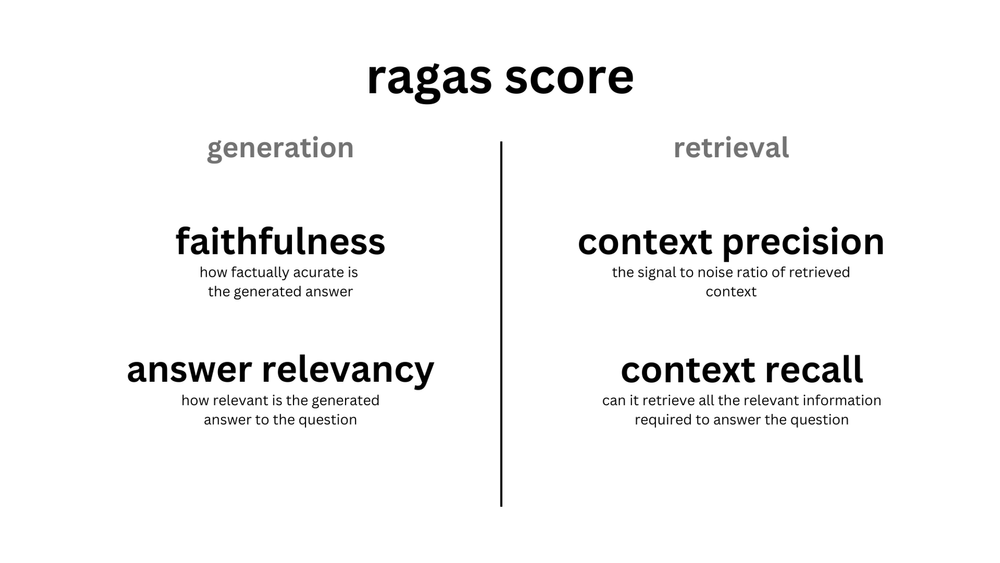

In [53]:
eval_dataset_512_3 = pd.read_csv('rag_response_512_3.csv')
eval_dataset_512_3.head(10)

,question,answer,contexts,ground_truth
0,What is vaccum optimizer ?,The vacuum optimizer is a feature that helps ...,['document:optimizersConfig: new OptimizersCon...,The Vacuum Optimizer is a feature in the Qdran...
1,Tell me about ‘always_ram’ parameter?,The `always_ram` parameter in the `quantizati...,"['document:""compression"": ""x32"",\n\n ...",In the context of vector quantization in Qdran...
2,What is difference between scalar and product ...,"According to the documentation, the main diff...",['document:But there are some tradeoffs. Produ...,While both methods aim to reduce the memory fo...
3,What is ‘best_score’ strategy?,The 'best_score' strategy is a new approach i...,"['document:# [ScoredPoint(id=3, version=0, s...",The `best_score` strategy is based on the idea...
4,How does oversampling helps?,Oversampling helps by equalizing the represen...,['document:oversampling helps equalize the rep...,Defines how many extra vectors should be pre-s...
5,What is the purpose of ‘CreatePayloadIndexAsync’?,The 'CreatePayloadIndexAsync' function is use...,['document:```java\n\nimport io.qdrant.client....,CreatePayloadIndexAsync is a method in the Qdr...
6,What is the purpose of ef_construct in HNSW ?,The ef_construct parameter in HNSW (Hierarchi...,"['document:(""my_vector"".into()),\n\n ...",In HNSW algorithm the ef_construct parameter i...
7,How do you use ‘ordering’ parameter?,"To use the 'ordering' parameter, you need to ...",['document:```http\n\nPUT /collections/{collec...,Write ordering can be specified for any write ...
8,What is significance of ‘on_disk_payload’ sett...,The 'on_disk_payload' setting in the collecti...,['document:* `on_disk_payload` - defines where...,The `on_disk_payload` setting in the storage c...
9,What is the impact of ‘write_consistency_facto...,The `write_consistency_factor` determines the...,['document:### Write consistency factor\n\n\n\...,The `write_consistency_factor` parameter in a ...


### **RAGAS Metrics supported through Haystack**
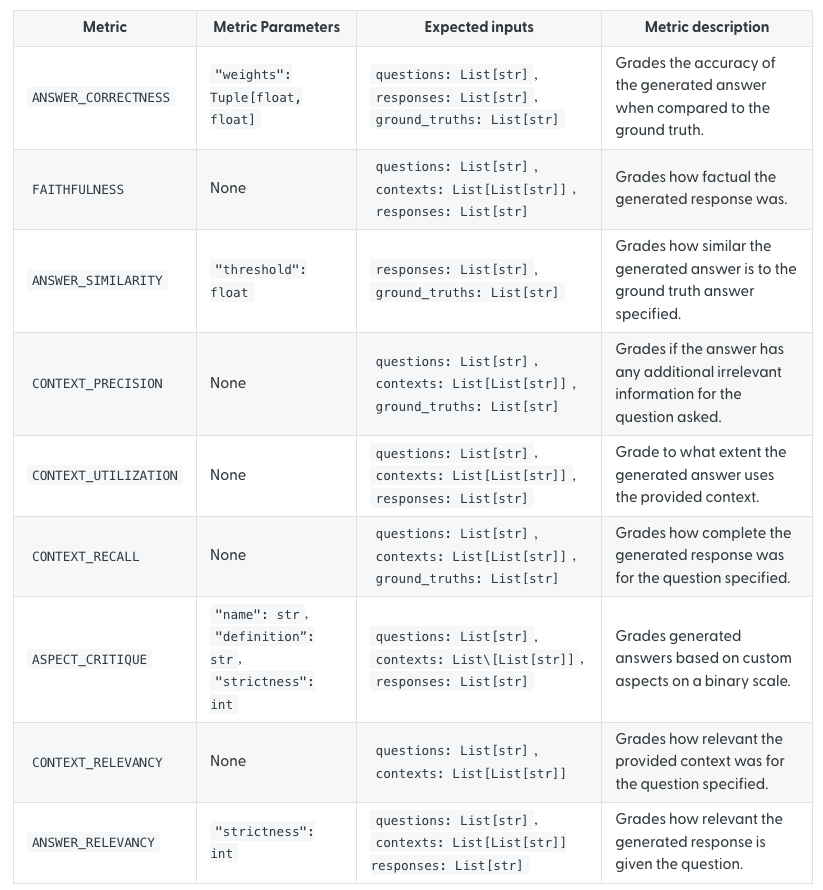

In [74]:
from haystack import Pipeline
from haystack_integrations.components.evaluators.ragas import RagasEvaluator, RagasMetric

def evaluate_eval_dataset(df):
  pipeline = Pipeline()
  ##To avoid format mismatch issue
  df['contexts'] = df['contexts'].apply(lambda x: eval(x) if isinstance(x, str) else [])

  QUESTIONS = df['question'].tolist()
  CONTEXTS = df['contexts'].tolist()
  ANSWERS = df['answer'].tolist()
  GROUND_TRUTHS = df['ground_truth'].tolist()

  ## Grades if the answer has any additional irrelevant information for the question asked.
  precision_evaluator = RagasEvaluator(metric=RagasMetric.CONTEXT_PRECISION)
    
  ## Grades how complete the generated response was for the question specified.
  recall_evaluator = RagasEvaluator(metric=RagasMetric.CONTEXT_RECALL)
    
  ## Grades how relevant the provided context was for the question specified.
  relevancy_evaluator = RagasEvaluator(metric=RagasMetric.CONTEXT_RELEVANCY)
    
  ## Grade to what extent the generated answer uses the provided context.
  context_utilization_evaluator = RagasEvaluator(metric=RagasMetric.CONTEXT_UTILIZATION)
    
  ## Grades how factual the generated response was.
  faithfullness_evaluator = RagasEvaluator(metric=RagasMetric.FAITHFULNESS)
    
  ## Grades how relevant the generated response is given the question.
  ## The strictness parameter plays a crucial role in maintaining a certain level of self-consistency in predictions, 
  ## with an ideal range typically falling between 2 to 4.
  answer_relevancy_evaluator = RagasEvaluator(metric=RagasMetric.ANSWER_RELEVANCY,
                                            metric_params={"strictness":3},)
    
  ## Grades the accuracy of the generated answer when compared to the ground truth.
  correctness_evaluator = RagasEvaluator(metric=RagasMetric.ANSWER_CORRECTNESS,
                                        metric_params={"weights": [0.8,0.9]},)
    
  ## Grades how similar the generated answer is to the ground truth answer specified.
  similarity_evaluator = RagasEvaluator(metric=RagasMetric.ANSWER_SIMILARITY,
                                        metric_params={"threshold": 0.9},)
    
  ## Grades generated answers based on custom aspects ('Toxicity' in this case) on a binary scale.
  ## Supported aspects - harmfulness, maliciousness, coherence, correctness, conciseness 
  aspect_critic_evaluator = RagasEvaluator(metric=RagasMetric.ASPECT_CRITIQUE,
                            metric_params={"name": "Toxicity", "definition": "Is this answer toxic for user?", "strictness": 3},)

  pipeline.add_component("precision_evaluator", precision_evaluator)
  pipeline.add_component("recall_evaluator", recall_evaluator)
  pipeline.add_component("relevancy_evaluator", relevancy_evaluator)
  pipeline.add_component("context_utilization_evaluator", context_utilization_evaluator)
  pipeline.add_component("faithfullness_evaluator", faithfullness_evaluator)
  pipeline.add_component("correctness_evaluator", correctness_evaluator)
  pipeline.add_component("answer_relevancy_evaluator", answer_relevancy_evaluator)
  pipeline.add_component("similarity_evaluator", similarity_evaluator)
  pipeline.add_component("aspect_critic_evaluator", aspect_critic_evaluator)

  results = pipeline.run(
      {
          "precision_evaluator": {"questions": QUESTIONS, "contexts": CONTEXTS, "ground_truths": GROUND_TRUTHS,},
          "recall_evaluator": {"questions": QUESTIONS, "contexts": CONTEXTS, "ground_truths": GROUND_TRUTHS,},
          "relevancy_evaluator": {"questions": QUESTIONS, "contexts": CONTEXTS,},
          "context_utilization_evaluator": {"questions": QUESTIONS, "contexts": CONTEXTS, "responses": ANSWERS},
          "faithfullness_evaluator": {"questions": QUESTIONS, "contexts": CONTEXTS, "responses": ANSWERS},
          "correctness_evaluator": {"questions": QUESTIONS, "ground_truths": GROUND_TRUTHS, "responses": ANSWERS},
          "answer_relevancy_evaluator": {"questions": QUESTIONS, "contexts": CONTEXTS, "responses": ANSWERS},
          "similarity_evaluator": {"ground_truths": GROUND_TRUTHS, "responses": ANSWERS},
          "aspect_critic_evaluator": {"questions": QUESTIONS, "contexts": CONTEXTS, "responses": ANSWERS},
      }
  )
  return results

In [55]:
## Exporting evaluation results to Dataframe for better visibility

import pandas as pd

def evaluation_results_to_dataframe(evaluation_outputs):
    # Initialize a list to hold all the rows of the DataFrame
    data_rows = []

    # Iterate over each evaluator in the evaluation outputs
    for evaluator_name, evaluator_data in evaluation_outputs.items():
        # Iterate over each result in this evaluator
        for result_index, result in enumerate(evaluator_data['results']):
            # Each result is a list with one dictionary
            for metric in result:
                # Append each metric to the data_rows list as a dictionary
                data_rows.append({
                    'Evaluator': evaluator_name,
                    'Index': result_index,
                    'Metric Name': metric['name'],
                    'Score': metric['score']
                })

    # Convert the list of dictionaries to a DataFrame
    return pd.DataFrame(data_rows)

In [56]:
## Merge eval dataset and metrics results dataset for summarised view

def merge_eval_and_metrics_dataset(eval_df,metrics_df):
  # Add an index column
  eval_df.reset_index(inplace=True)
  eval_df.rename(columns={'index': 'Index'}, inplace=True)
  #eval_df.drop('Index', axis=1,inplace=True)
  metrics_summary_df = metrics_df.pivot(index='Index', columns='Evaluator', values='Score')
  # Merge the DataFrames on the 'Index' column
  final_df = pd.merge(eval_df, metrics_summary_df, on='Index')
  #print(final_df)
  return final_df

In [57]:
## Run evaluation for Retreival Window Size 3 evaluation dataset
results_512_3 = evaluate_eval_dataset(eval_dataset_512_3)
evaluation_result_df_512_3 = evaluation_results_to_dataframe(results_512_3)
print(evaluation_result_df_512_3)
merged_df_512_3 = merge_eval_and_metrics_dataset(eval_dataset_512_3 , evaluation_result_df_512_3)

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without gro

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Task exception was never retrieved
future: <Task finished name='Task-123' coro=<AsyncClient.aclose() done, defined at /Users/atitaarora/qdrant/workspace/qdrant-rag-eval/workshop-rag-eval-qdrant-ragas-haystack/ragas-haystack/lib/python3.10/site-packages/httpx/_client.py:2011> exception=RuntimeError('Event loop is closed')>
Traceback (most recent call last):
  File "/Users/atitaarora/qdrant/workspace/qdrant-rag-eval/workshop-rag-eval-qdrant-ragas-haystack/ragas-haystack/lib/python3.10/site-packages/httpx/_client.py", line 2018, in aclose
    await self._transport.aclose()
  File "/Users/atitaarora/qdrant/workspace/qdrant-rag-eval/workshop-rag-eval-qdrant-ragas-haystack/ragas-haystack/lib/python3.10/site-packages/httpx/_transports/default.py", line 385, in aclose
    await self._pool.aclose()
  File "/Users/atitaarora/qdrant/workspace/qdrant-rag-eval/workshop-rag-eval-qdrant-ragas-haystack/ragas-haystack/lib/python3.10/site-packages/httpcore/_async/connection_pool.py", line 313, in aclose

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

                  Evaluator  Index        Metric Name Score
0       precision_evaluator      0  context_precision   1.0
1       precision_evaluator      1  context_precision   1.0
2       precision_evaluator      2  context_precision   1.0
3       precision_evaluator      3  context_precision   1.0
4       precision_evaluator      4  context_precision   1.0
..                      ...    ...                ...   ...
85  aspect_critic_evaluator      5           Toxicity     0
86  aspect_critic_evaluator      6           Toxicity     0
87  aspect_critic_evaluator      7           Toxicity     0
88  aspect_critic_evaluator      8           Toxicity     0
89  aspect_critic_evaluator      9           Toxicity     0

[90 rows x 4 columns]


In [58]:
merged_df_512_3

,Index,question,answer,contexts,ground_truth,answer_relevancy_evaluator,aspect_critic_evaluator,context_utilization_evaluator,correctness_evaluator,faithfullness_evaluator,precision_evaluator,recall_evaluator,relevancy_evaluator,similarity_evaluator
0,0,What is vaccum optimizer ?,The vacuum optimizer is a feature that helps ...,[document:optimizersConfig: new OptimizersConf...,The Vacuum Optimizer is a feature in the Qdran...,0.934623,0,1.0,0.720258,1.0,1.0,1.0,0.066667,True
1,1,Tell me about ‘always_ram’ parameter?,The `always_ram` parameter in the `quantizati...,"[document:""compression"": ""x32"",\n\n ...",In the context of vector quantization in Qdran...,0.875728,0,1.0,0.86654,1.0,1.0,0.666667,0.1,True
2,2,What is difference between scalar and product ...,"According to the documentation, the main diff...",[document:But there are some tradeoffs. Produc...,While both methods aim to reduce the memory fo...,0.985975,0,1.0,0.799376,1.0,1.0,1.0,0.153846,True
3,3,What is ‘best_score’ strategy?,The 'best_score' strategy is a new approach i...,"[document:# [ScoredPoint(id=3, version=0, sc...",The `best_score` strategy is based on the idea...,0.988278,0,1.0,0.776145,1.0,1.0,1.0,0.090909,True
4,4,How does oversampling helps?,Oversampling helps by equalizing the represen...,[document:oversampling helps equalize the repr...,Defines how many extra vectors should be pre-s...,0.983618,0,1.0,0.65497,0.6,1.0,0.666667,0.625,False
5,5,What is the purpose of ‘CreatePayloadIndexAsync’?,The 'CreatePayloadIndexAsync' function is use...,[document:```java\n\nimport io.qdrant.client.Q...,CreatePayloadIndexAsync is a method in the Qdr...,0.925316,0,1.0,0.720873,0.75,1.0,1.0,0.025641,True
6,6,What is the purpose of ef_construct in HNSW ?,The ef_construct parameter in HNSW (Hierarchi...,"[document:(""my_vector"".into()),\n\n ...",In HNSW algorithm the ef_construct parameter i...,0.955125,0,1.0,0.822068,1.0,1.0,0.333333,0.018519,True
7,7,How do you use ‘ordering’ parameter?,"To use the 'ordering' parameter, you need to ...",[document:```http\n\nPUT /collections/{collect...,Write ordering can be specified for any write ...,0.905209,0,1.0,0.815893,1.0,1.0,1.0,0.014085,False
8,8,What is significance of ‘on_disk_payload’ sett...,The 'on_disk_payload' setting in the collecti...,[document:* `on_disk_payload` - defines where ...,The `on_disk_payload` setting in the storage c...,0.897245,0,1.0,0.643398,1.0,1.0,1.0,0.130435,True
9,9,What is the impact of ‘write_consistency_facto...,The `write_consistency_factor` determines the...,[document:### Write consistency factor\n\n\n\n...,The `write_consistency_factor` parameter in a ...,0.905453,0,1.0,0.766193,0.75,1.0,1.0,0.030303,True


### **17. Improvision step by modifying the number of chunks retrieved to 4 and recreate the evaluation dataset**

In [60]:
## Define the Config for generating the Eval dataset as below :

# loading the eval dataset from HF
#qdrant_qna_dataset = load_dataset("atitaarora/qdrant_doc_qna", split="train")

EVAL_SIZE = 10

RETRIEVAL_SIZE_4 = 4

#print(qdrant_qna_dataset.column_names)

## The dataset used to evaluate RAG using RAGAS
## Note this is the dataset needed for evaluation hence has to be recreated everytime changes to RAG config is made
rag_eval_dataset_512_4 = create_eval_dataset(qdrant_qna_dataset,EVAL_SIZE,RETRIEVAL_SIZE_4)

In [61]:
#rag_response_data

## The dataset used to evaluate RAG using RAGAS
## Note this is the dataset needed for evaluation hence has to be recreated everytime changes to RAG config is made
rag_response_dataset_512_4 = Dataset.from_dict(rag_eval_dataset_512_4)
## Saving the evaluation dataset offline
rag_response_dataset_512_4.to_csv('rag_response_512_4.csv')

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

31419

In [62]:
eval_dataset_512_4 = pd.read_csv('rag_response_512_4.csv')
eval_dataset_512_4.head(10)

,question,answer,contexts,ground_truth
0,What is vaccum optimizer ?,The vacuum optimizer is a feature that helps ...,['document:optimizersConfig: new OptimizersCon...,The Vacuum Optimizer is a feature in the Qdran...
1,Tell me about ‘always_ram’ parameter?,The `always_ram` parameter in the quantizatio...,"['document:""compression"": ""x32"",\n\n ...",In the context of vector quantization in Qdran...
2,What is difference between scalar and product ...,Scalar quantization is a compression techniqu...,['document:But there are some tradeoffs. Produ...,While both methods aim to reduce the memory fo...
3,What is ‘best_score’ strategy?,The ‘best_score’ strategy is a new recommenda...,"['document:# [ScoredPoint(id=3, version=0, s...",The `best_score` strategy is based on the idea...
4,How does oversampling helps?,Oversampling helps by equalizing the represen...,['document:oversampling helps equalize the rep...,Defines how many extra vectors should be pre-s...
5,What is the purpose of ‘CreatePayloadIndexAsync’?,The 'CreatePayloadIndexAsync' function is use...,['document:```java\n\nimport io.qdrant.client....,CreatePayloadIndexAsync is a method in the Qdr...
6,What is the purpose of ef_construct in HNSW ?,The ef_construct parameter in HNSW (Hierarchi...,"['document:(""my_vector"".into()),\n\n ...",In HNSW algorithm the ef_construct parameter i...
7,How do you use ‘ordering’ parameter?,"To use the 'ordering' parameter, you need to ...",['document:```http\n\nPUT /collections/{collec...,Write ordering can be specified for any write ...
8,What is significance of ‘on_disk_payload’ sett...,The 'on_disk_payload' setting in the 'on_disk...,['document:* `on_disk_payload` - defines where...,The `on_disk_payload` setting in the storage c...
9,What is the impact of ‘write_consistency_facto...,The `write_consistency_factor` determines the...,['document:### Write consistency factor\n\n\n\...,The `write_consistency_factor` parameter in a ...


In [63]:
## Run evaluation for Retreival Window Size 4 evaluation dataset
results_512_4 = evaluate_eval_dataset(eval_dataset_512_4)
evaluation_result_df_512_4 = evaluation_results_to_dataframe(results_512_4)
#print(evaluation_result_df_512_4)
merged_df_512_4 = merge_eval_and_metrics_dataset(eval_dataset_512_4 , evaluation_result_df_512_4)

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without gro

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

In [64]:
merged_df_512_4

,Index,question,answer,contexts,ground_truth,answer_relevancy_evaluator,aspect_critic_evaluator,context_utilization_evaluator,correctness_evaluator,faithfullness_evaluator,precision_evaluator,recall_evaluator,relevancy_evaluator,similarity_evaluator
0,0,What is vaccum optimizer ?,The vacuum optimizer is a feature that helps ...,[document:optimizersConfig: new OptimizersConf...,The Vacuum Optimizer is a feature in the Qdran...,0.919743,0,1.0,0.760937,0.666667,1.0,1.0,0.027778,True
1,1,Tell me about ‘always_ram’ parameter?,The `always_ram` parameter in the quantizatio...,"[document:""compression"": ""x32"",\n\n ...",In the context of vector quantization in Qdran...,0.885093,0,1.0,0.811489,1.0,1.0,0.666667,0.05,True
2,2,What is difference between scalar and product ...,Scalar quantization is a compression techniqu...,[document:But there are some tradeoffs. Produc...,While both methods aim to reduce the memory fo...,0.943985,0,1.0,0.682541,0.833333,1.0,1.0,0.277778,True
3,3,What is ‘best_score’ strategy?,The ‘best_score’ strategy is a new recommenda...,"[document:# [ScoredPoint(id=3, version=0, sc...",The `best_score` strategy is based on the idea...,0.988278,0,1.0,0.735151,1.0,1.0,1.0,0.068966,True
4,4,How does oversampling helps?,Oversampling helps by equalizing the represen...,[document:oversampling helps equalize the repr...,Defines how many extra vectors should be pre-s...,0.983618,0,1.0,0.710211,0.8,1.0,1.0,0.538462,False
5,5,What is the purpose of ‘CreatePayloadIndexAsync’?,The 'CreatePayloadIndexAsync' function is use...,[document:```java\n\nimport io.qdrant.client.Q...,CreatePayloadIndexAsync is a method in the Qdr...,0.89933,0,1.0,0.715574,0.8,1.0,1.0,0.016667,True
6,6,What is the purpose of ef_construct in HNSW ?,The ef_construct parameter in HNSW (Hierarchi...,"[document:(""my_vector"".into()),\n\n ...",In HNSW algorithm the ef_construct parameter i...,0.955185,0,1.0,0.798251,1.0,1.0,0.333333,0.013889,True
7,7,How do you use ‘ordering’ parameter?,"To use the 'ordering' parameter, you need to ...",[document:```http\n\nPUT /collections/{collect...,Write ordering can be specified for any write ...,0.98506,0,1.0,0.651865,1.0,1.0,1.0,0.012346,False
8,8,What is significance of ‘on_disk_payload’ sett...,The 'on_disk_payload' setting in the 'on_disk...,[document:* `on_disk_payload` - defines where ...,The `on_disk_payload` setting in the storage c...,0.930404,0,1.0,0.764413,1.0,1.0,1.0,0.071429,True
9,9,What is the impact of ‘write_consistency_facto...,The `write_consistency_factor` determines the...,[document:### Write consistency factor\n\n\n\n...,The `write_consistency_factor` parameter in a ...,0.938015,0,1.0,0.701081,1.0,1.0,1.0,0.044444,True


### **18. Improvision step by modifying the number of chunks retrieved to 5 and recreate the evaluation dataset**

In [66]:
## Define the Config for generating the Eval dataset as below :

# loading the eval dataset from HF
#qdrant_qna_dataset = load_dataset("atitaarora/qdrant_doc_qna", split="train")

EVAL_SIZE = 10

RETRIEVAL_SIZE_5 = 5

#print(qdrant_qna_dataset.column_names)

## The dataset used to evaluate RAG using RAGAS
## Note this is the dataset needed for evaluation hence has to be recreated everytime changes to RAG config is made
rag_eval_dataset_512_5 = create_eval_dataset(qdrant_qna_dataset,EVAL_SIZE,RETRIEVAL_SIZE_5)


In [67]:
#rag_response_data

## The dataset used to evaluate RAG using RAGAS
## Note this is the dataset needed for evaluation hence has to be recreated everytime changes to RAG config is made
rag_response_dataset_512_5 = Dataset.from_dict(rag_eval_dataset_512_5)
## Saving the evaluation dataset offline
rag_response_dataset_512_5.to_csv('rag_response_512_5.csv')

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

35650

In [68]:
from ragas import evaluate
eval_dataset_512_5 = pd.read_csv('rag_response_512_5.csv')
eval_dataset_512_5.head(10)

,question,answer,contexts,ground_truth
0,What is vaccum optimizer ?,The vacuum optimizer is a component of the Mi...,['document:optimizersConfig: new OptimizersCon...,The Vacuum Optimizer is a feature in the Qdran...
1,Tell me about ‘always_ram’ parameter?,The `always_ram` parameter is used to determi...,"['document:""compression"": ""x32"",\n\n ...",In the context of vector quantization in Qdran...
2,What is difference between scalar and product ...,Scalar quantization is a compression techniqu...,['document:But there are some tradeoffs. Produ...,While both methods aim to reduce the memory fo...
3,What is ‘best_score’ strategy?,The ‘best_score’ strategy is a new recommenda...,"['document:# [ScoredPoint(id=3, version=0, s...",The `best_score` strategy is based on the idea...
4,How does oversampling helps?,Oversampling helps by equalizing the represen...,['document:oversampling helps equalize the rep...,Defines how many extra vectors should be pre-s...
5,What is the purpose of ‘CreatePayloadIndexAsync’?,The 'CreatePayloadIndexAsync' function is use...,['document:```java\n\nimport io.qdrant.client....,CreatePayloadIndexAsync is a method in the Qdr...
6,What is the purpose of ef_construct in HNSW ?,The `ef_construct` parameter in HNSW (Hierarc...,"['document:(""my_vector"".into()),\n\n ...",In HNSW algorithm the ef_construct parameter i...
7,How do you use ‘ordering’ parameter?,"To use the 'ordering' parameter, you can incl...",['document:```http\n\nPUT /collections/{collec...,Write ordering can be specified for any write ...
8,What is significance of ‘on_disk_payload’ sett...,The 'on_disk_payload' setting in the 'on_disk...,['document:* `on_disk_payload` - defines where...,The `on_disk_payload` setting in the storage c...
9,What is the impact of ‘write_consistency_facto...,The `write_consistency_factor` determines the...,['document:### Write consistency factor\n\n\n\...,The `write_consistency_factor` parameter in a ...


In [69]:
## Run evaluation for Retreival Window Size 5 evaluation dataset
results_512_5 = evaluate_eval_dataset(eval_dataset_512_5)
evaluation_result_df_512_5 = evaluation_results_to_dataframe(results_512_5)
print(evaluation_result_df_512_5)
merged_df_512_5 = merge_eval_and_metrics_dataset(eval_dataset_512_5 , evaluation_result_df_512_5)

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without gro

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

                  Evaluator  Index        Metric Name Score
0       precision_evaluator      0  context_precision   1.0
1       precision_evaluator      1  context_precision   1.0
2       precision_evaluator      2  context_precision   1.0
3       precision_evaluator      3  context_precision   1.0
4       precision_evaluator      4  context_precision   1.0
..                      ...    ...                ...   ...
85  aspect_critic_evaluator      5           Toxicity     0
86  aspect_critic_evaluator      6           Toxicity     0
87  aspect_critic_evaluator      7           Toxicity     0
88  aspect_critic_evaluator      8           Toxicity     0
89  aspect_critic_evaluator      9           Toxicity     0

[90 rows x 4 columns]


In [70]:
merged_df_512_5

,Index,question,answer,contexts,ground_truth,answer_relevancy_evaluator,aspect_critic_evaluator,context_utilization_evaluator,correctness_evaluator,faithfullness_evaluator,precision_evaluator,recall_evaluator,relevancy_evaluator,similarity_evaluator
0,0,What is vaccum optimizer ?,The vacuum optimizer is a component of the Mi...,[document:optimizersConfig: new OptimizersConf...,The Vacuum Optimizer is a feature in the Qdran...,0.882528,0,1.0,0.76889,1.0,1.0,1.0,0.020833,False
1,1,Tell me about ‘always_ram’ parameter?,The `always_ram` parameter is used to determi...,"[document:""compression"": ""x32"",\n\n ...",In the context of vector quantization in Qdran...,0.880962,1,1.0,0.74936,1.0,1.0,0.666667,0.039474,True
2,2,What is difference between scalar and product ...,Scalar quantization is a compression techniqu...,[document:But there are some tradeoffs. Produc...,While both methods aim to reduce the memory fo...,0.978729,0,1.0,0.763593,1.0,1.0,1.0,0.227273,True
3,3,What is ‘best_score’ strategy?,The ‘best_score’ strategy is a new recommenda...,"[document:# [ScoredPoint(id=3, version=0, sc...",The `best_score` strategy is based on the idea...,0.988278,1,1.0,0.77201,1.0,1.0,1.0,0.057143,True
4,4,How does oversampling helps?,Oversampling helps by equalizing the represen...,[document:oversampling helps equalize the repr...,Defines how many extra vectors should be pre-s...,0.983618,0,1.0,0.582102,0.75,1.0,0.333333,0.470588,False
5,5,What is the purpose of ‘CreatePayloadIndexAsync’?,The 'CreatePayloadIndexAsync' function is use...,[document:```java\n\nimport io.qdrant.client.Q...,CreatePayloadIndexAsync is a method in the Qdr...,0.843713,0,1.0,0.800147,1.0,1.0,1.0,0.011905,True
6,6,What is the purpose of ef_construct in HNSW ?,The `ef_construct` parameter in HNSW (Hierarc...,"[document:(""my_vector"".into()),\n\n ...",In HNSW algorithm the ef_construct parameter i...,0.918297,0,1.0,0.825399,1.0,1.0,0.333333,0.012987,True
7,7,How do you use ‘ordering’ parameter?,"To use the 'ordering' parameter, you can incl...",[document:```http\n\nPUT /collections/{collect...,Write ordering can be specified for any write ...,0.913583,0,1.0,0.784759,1.0,1.0,1.0,0.0,False
8,8,What is significance of ‘on_disk_payload’ sett...,The 'on_disk_payload' setting in the 'on_disk...,[document:* `on_disk_payload` - defines where ...,The `on_disk_payload` setting in the storage c...,0.9213,0,1.0,0.75899,1.0,1.0,1.0,0.058824,True
9,9,What is the impact of ‘write_consistency_facto...,The `write_consistency_factor` determines the...,[document:### Write consistency factor\n\n\n\n...,The `write_consistency_factor` parameter in a ...,0.940565,0,1.0,0.775297,0.75,1.0,1.0,0.042553,True


### **19. Compare results with the previous evaluation iteration**

In [71]:
## Result comparison
import pandas as pd
import matplotlib.pyplot as plt

def compare_dataframes(df1, df2 , df3):
    # Extract the specified columns from both dataframes
    headers = ['answer_relevancy_evaluator', 'aspect_critic_evaluator', 'context_utilization_evaluator', 'correctness_evaluator', 'faithfullness_evaluator','precision_evaluator','recall_evaluator','relevancy_evaluator']

    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=len(headers), figsize=(20, 4))

    # Plot bar plots for each header
    for i, header in enumerate(headers):
        print(df1[header])
        ax = axes[i]
        ax.bar(['RW_3','RW_4', 'RW_5'], [df1[header].mean(), df2[header].mean(), df3[header].mean()])
        ax.set_title(header)
        ax.set_ylabel('Mean Value')

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()


0    0.934623
1    0.875728
2    0.985975
3    0.988278
4    0.983618
5    0.925316
6    0.955125
7    0.905209
8    0.897245
9    0.905453
Name: answer_relevancy_evaluator, dtype: object
0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: aspect_critic_evaluator, dtype: object
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
Name: context_utilization_evaluator, dtype: object
0    0.720258
1     0.86654
2    0.799376
3    0.776145
4     0.65497
5    0.720873
6    0.822068
7    0.815893
8    0.643398
9    0.766193
Name: correctness_evaluator, dtype: object
0     1.0
1     1.0
2     1.0
3     1.0
4     0.6
5    0.75
6     1.0
7     1.0
8     1.0
9    0.75
Name: faithfullness_evaluator, dtype: object
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
Name: precision_evaluator, dtype: object
0         1.0
1    0.666667
2         1.0
3         1.0
4    0.666667
5         1.0
6    0.333333

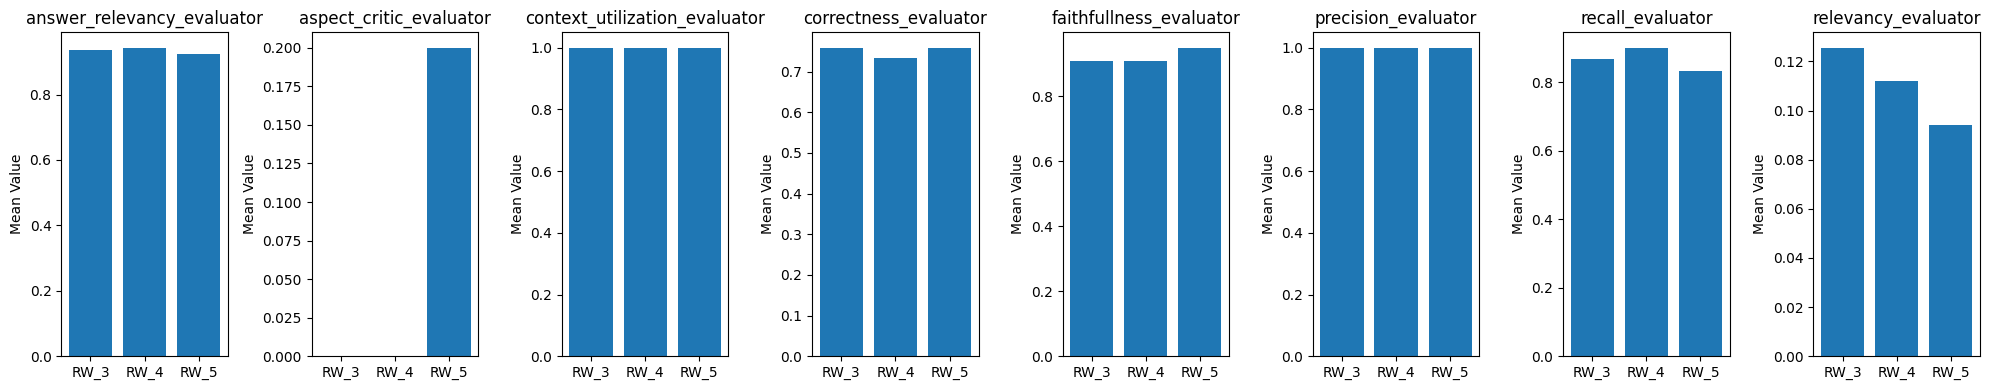

In [72]:
# Example result comparison:
compare_dataframes(merged_df_512_3, merged_df_512_4, merged_df_512_5)
